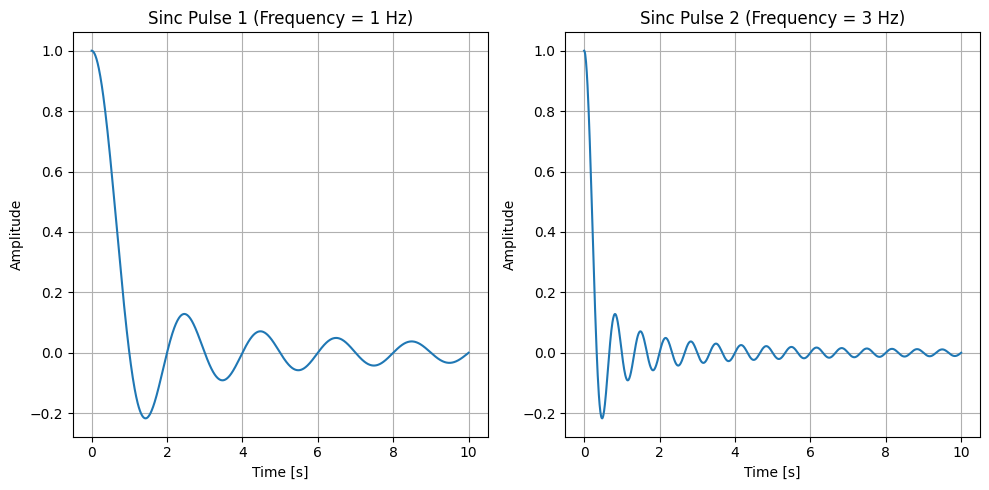

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define sampling rate and time for generating pulses
sampling_rate = 1000 
t = np.linspace(0, 10, sampling_rate)  

# Helper function to generate sinc pulses
def generate_sinc_pulse(frequency):
    pulse = np.sinc(frequency * (t - 0))  
    return pulse / np.max(np.abs(pulse))  # Normalize pulse

# Generate two examples of sinc pulses with different frequencies
sinc_pulse1 = generate_sinc_pulse(1)  # Wider pulse with lower frequency
sinc_pulse2 = generate_sinc_pulse(3)  # Narrower pulse with higher frequency

# Plot the sinc pulses
plt.figure(figsize=(10, 5))

# Plot Sinc Pulse 1
plt.subplot(1, 2, 1)
plt.plot(t, sinc_pulse1)
plt.title("Sinc Pulse 1 (Frequency = 1 Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()

# Plot Sinc Pulse 2
plt.subplot(1, 2, 2)
plt.plot(t, sinc_pulse2)
plt.title("Sinc Pulse 2 (Frequency = 3 Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

# Helper function to calculate the distance from source to microphone with a reflection
def dist(src, pt, mic):
    """Calculate the distance from the source to a microphone, reflecting from a given point."""
    d1 = np.linalg.norm(np.array(src) - np.array(pt))  
    d2 = np.linalg.norm(np.array(pt) - np.array(mic)) 
    return d1 + d2



In order to create pulses similar to the provided sinc pulses, we must modify the SincP parameter, which determines the sinc pulse width.

1. Reducing SincP leads to a wider pulse with slower vibrations, resulting in DAS images that are smoother and less intricate. Overlap of pulses may cause difficulty in distinguishing distinct reflections.

2. Raising SincP: Leads to a more compact pulse with quicker oscillations, resulting in a more precise and intricate DAS image, although it could also be more susceptible to interference.

Significant effect on Distributed Antenna System image:

1. A reduction in SincP size (wider pulses) results in a more blurred image as a result of pulses overlapping.

2. A greater SincP value (which results in narrower pulses) produces a more precise image with improved obstacle detection, however, it may also lead to heightened sensitivity to noise.

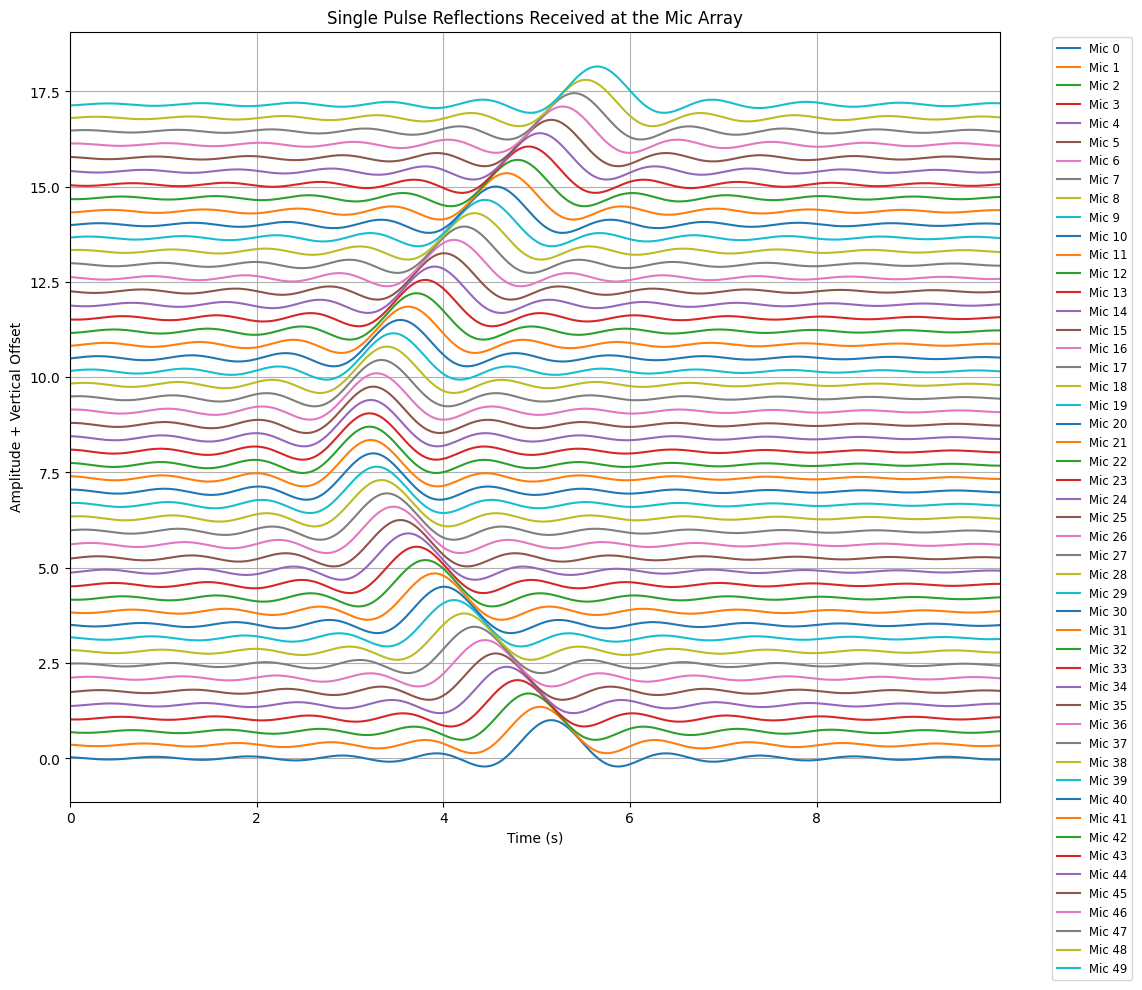

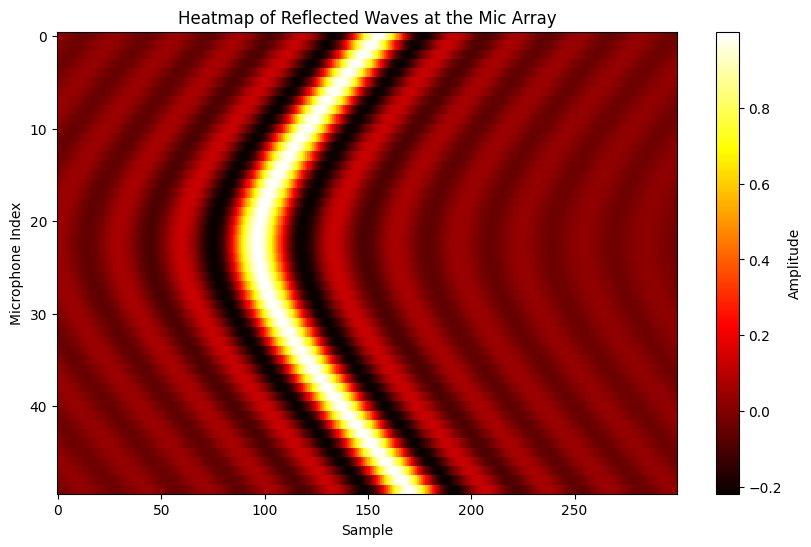

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def generate_microphone_outputs(Nmics, Nsamp, C, dist_per_samp, pitch, src, obstacle, SincP):
    mics = [(0, (i - Nmics // 2) * pitch) for i in range(Nmics)]

    t = np.arange(Nsamp) * dist_per_samp / C

    def source_pulse(t, SincP):
        return np.sinc(SincP * (t - 0.5))  # Original sinc pulse centered at 0.5 seconds

    # Helper function to compute total distance from source to microphone via obstacle
    def total_distance(src, obstacle, mic):
        d1 = np.sqrt((src[0] - obstacle[0]) ** 2 + (src[1] - obstacle[1]) ** 2)  # Distance from source to obstacle
        d2 = np.sqrt((obstacle[0] - mic[0]) ** 2 + (obstacle[1] - mic[1]) ** 2)  # Distance from obstacle to mic
        return d1 + d2

    # Generate mic outputs
    mic_outputs = np.zeros((Nmics, Nsamp))

    for i, mic in enumerate(mics):
        # Direct path distance
        direct_distance = np.sqrt((src[0] - mic[0]) ** 2 + (src[1] - mic[1]) ** 2)
        direct_delay = direct_distance / C

        # Reflected path distance
        reflected_distance = total_distance(src, obstacle, mic)
        reflected_delay = reflected_distance / C

        # Calculate the pulse signal with delays for reflected paths only
        # Only consider the reflected pulse to avoid overlapping with direct path
        reflected_pulse = source_pulse(t - reflected_delay, SincP)

        # Assign the reflected pulse to mic output
        mic_outputs[i, :] = reflected_pulse

    return t, mic_outputs

def plot_mic_outputs(t, mic_outputs):
    # Plot each microphone's output with vertical separation to avoid overlap
    plt.figure(figsize=(12, 10))
    for i in range(mic_outputs.shape[0]):
        plt.plot(t, mic_outputs[i] + i * 0.35, label=f'Mic {i}')  # Offset each plot vertically
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude + Vertical Offset')
    plt.title('Single Pulse Reflections Received at the Mic Array')
    plt.xlim([0, max(t)])  # Adjust x-axis limits to better visualize
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()

    # Plot heatmap of all mic outputs for an alternative view
    plt.figure(figsize=(10, 6))
    plt.imshow(mic_outputs, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar(label='Amplitude')
    plt.title('Heatmap of Reflected Waves at the Mic Array')
    plt.xlabel('Sample')
    plt.ylabel('Microphone Index')
    plt.show()

Nmics = 50                # Number of microphones, adjusted for a smaller array
Nsamp = 300               # Number of samples in time, increased for finer resolution
C = 1.5                   # Speed of sound in the medium 
dist_per_samp = 0.05      # Distance per sample, affects sampling rate 
pitch = 0.2               # Spacing between microphones 
src = (0, 0)              # Source location 
obstacle = (2, -0.5)      # Obstacle location 
SincP = 2.0               # Parameter to control the width of the sinc pulse 

t, mic_outputs = generate_microphone_outputs(Nmics, Nsamp, C, dist_per_samp, pitch, src, obstacle, SincP)
plot_mic_outputs(t, mic_outputs)


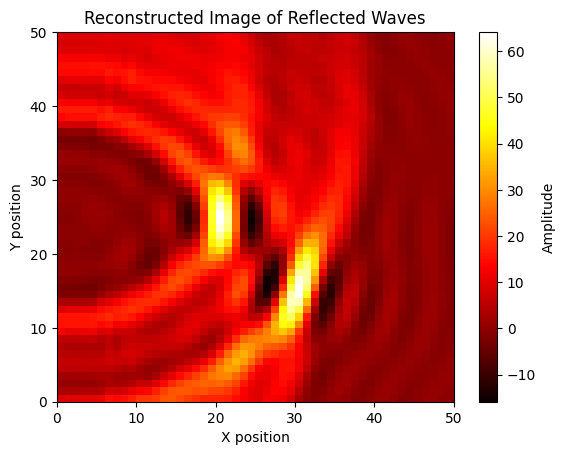

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_mics = 64               # Number of microphones
num_samples = 200           # Number of samples in time
sound_speed = 2.0           # Speed of sound in the medium (m/s)
distance_per_sample = 0.1   # Distance per sample
mic_spacing = 0.1           # Spacing between microphones
source_location = (0, 0)    # Source location (x, y)
pulse_width = 5.0           # Width of the sinc pulse

# Load microphone data from rx2.txt
mic_signals = np.loadtxt('rx2.txt')  # Shape should be (num_samples, num_mics)

# Ensure that mic_signals matches expected dimensions (transpose if necessary)
if mic_signals.shape != (num_mics, num_samples):
    mic_signals = mic_signals.T

# Delay-and-Sum Beamforming
def delay_and_sum(mic_signals, num_mics, num_samples, sound_speed, mic_spacing, grid_size=(50, 50)):
    grid_x, grid_y = grid_size
    grid = np.zeros(grid_size)
    mic_y_positions = [(i - num_mics // 2) * mic_spacing for i in range(num_mics)]
    time_axis = np.arange(num_samples) * distance_per_sample / sound_speed
    
    for ix in range(grid_x):
        for iy in range(grid_y):
            # Determine grid point (x, y)
            x = ix * mic_spacing
            y = (iy - grid_y // 2) * mic_spacing
            
            # Distance from source to grid point
            src_to_grid = np.sqrt((source_location[0] - x)**2 + (source_location[1] - y)**2)
            
            # Summing mic signals based on calculated delays
            summed_signals = 0.0
            for i, mic_y in enumerate(mic_y_positions):
                # Distance from grid point to microphone
                grid_to_mic = np.sqrt((x - 0)**2 + (y - mic_y)**2)
                total_distance = src_to_grid + grid_to_mic
                delay = total_distance / sound_speed
                
                # Get corresponding sample in time domain
                sample_index = int(delay / (distance_per_sample / sound_speed))
                if 0 <= sample_index < num_samples:
                    summed_signals += mic_signals[i, sample_index]
            
            grid[ix, iy] = summed_signals  # Store summed signal in grid
    
    return grid

# Reconstruct image using DAS
reconstructed_grid = delay_and_sum(mic_signals, num_mics, num_samples, sound_speed, mic_spacing)

# Plot the reconstructed image
plt.imshow(reconstructed_grid.T, origin='lower', extent=(0, reconstructed_grid.shape[0], 0, reconstructed_grid.shape[1]),
           cmap='hot', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('Reconstructed Image of Reflected Waves')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()


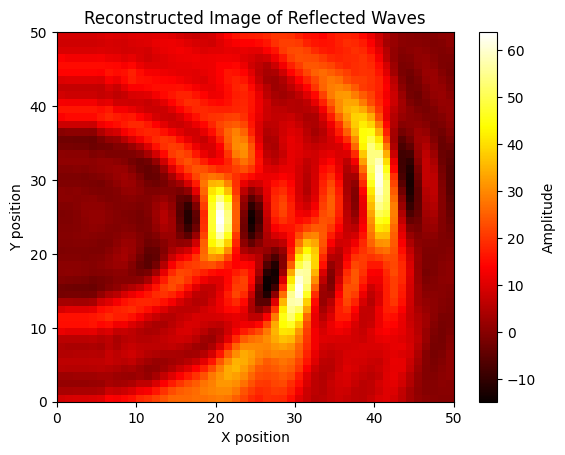

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_mics = 64               # Number of microphones
num_samples = 200           # Number of samples in time
sound_speed = 2.0           # Speed of sound in the medium
dist_per_sample = 0.1       # Distance per sample
mic_spacing = 0.1           # Spacing between microphones
source_location = (0, 0)    # Source location (x, y)
pulse_width = 5.0           # Width of the sinc pulse

# Load microphone data from rx3.txt
mic_signals = np.loadtxt('rx3.txt')  # Shape should be (num_samples, num_mics)

# Ensure that mic_signals matches expected dimensions (transpose if necessary)
if mic_signals.shape != (num_mics, num_samples):
    mic_signals = mic_signals.T

# Delay-and-Sum Beamforming
def delay_and_sum(mic_signals, num_mics, num_samples, sound_speed, mic_spacing, grid_size=(50, 50)):
    grid_x, grid_y = grid_size
    grid = np.zeros(grid_size)
    mic_y_positions = [(i - num_mics // 2) * mic_spacing for i in range(num_mics)]
    time_axis = np.arange(num_samples) * dist_per_sample / sound_speed
    
    for ix in range(grid_x):
        for iy in range(grid_y):
            # Determine grid point (x, y)
            x = ix * mic_spacing
            y = (iy - grid_y // 2) * mic_spacing
            
            # Distance from source to grid point
            src_to_grid = np.sqrt((source_location[0] - x)**2 + (source_location[1] - y)**2)
            
            # Summing mic signals based on calculated delays
            summed_signals = 0.0
            for i, mic_y in enumerate(mic_y_positions):
                # Distance from grid point to microphone
                grid_to_mic = np.sqrt((x - 0)**2 + (y - mic_y)**2)
                total_distance = src_to_grid + grid_to_mic
                delay = total_distance / sound_speed
                
                # Get corresponding sample in time domain
                sample_index = int(delay / (dist_per_sample / sound_speed))
                if 0 <= sample_index < num_samples:
                    summed_signals += mic_signals[i, sample_index]
            
            grid[ix, iy] = summed_signals  # Store summed signal in grid
    
    return grid

# Reconstruct image using DAS
reconstructed_grid = delay_and_sum(mic_signals, num_mics, num_samples, sound_speed, mic_spacing)

plt.imshow(reconstructed_grid.T, origin='lower', extent=(0, reconstructed_grid.shape[0], 0, reconstructed_grid.shape[1]),
           cmap='hot', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('Reconstructed Image of Reflected Waves')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()


1. Maximum Amplitude Coordinates (30, 22)
   The coordinates (30, 22) indicate the obstacle's location, as determined by the DAS algorithm, which calculates positions using time delays between the microphones. The peak amplitude here suggests constructive interference across all microphone signals, revealing the obstacle’s position accurately.

2. Limits of Obstacle Coordinates in Image Reconstruction  
   The maximum detectable coordinates for an obstacle depend on the microphone array’s reach and arrangement. If the obstacle is positioned too far or outside the array’s effective range, localization accuracy drops. This maximum range is influenced by the array’s configuration and signal power.

3. Impact of Reducing 𝐶 
   Lowering 𝐶 makes the image sharper by narrowing the sinc pulse width, localizing the signal more precisely and improving resolution. However, decreasing 𝐶 too much can cause undersampling or aliasing, creating a trade-off between resolution and signal integrity.
   
4. Increasing N_mics (microphones) improves the spatial resolution, making the reconstructed image sharper and more accurate, as more data points help pinpoint the obstacle more precisely. Conversely, decreasing N_mics reduces resolution, leading to a blurrier image.

Increasing N_samp (samples) improves time resolution, allowing more accurate delay calculations and sharper images. Fewer samples decrease time resolution, resulting in less precise localization and lower image quality.

Experiment:
- \( N_mics = 8, 32, 64 \) and \( N_samp = 50, 100, 200 \) will produce images with varying clarity:
  - \( N_mics = 8 \), \( N_samp = 50 \): Lowest resolution.
  - \( N_mics = 32 \), \( N_samp = 100 \): Moderate resolution.
  - \( N_mics = 64 \), \( N_samp = 200 \): Highest resolution and accuracy.
